In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
z_dim=128

In [3]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self,z_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,z_dim),
        )
        self.decoder =torch.nn.Sequential(
            torch.nn.Linear(z_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
           torch.nn.ReLU(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        #x = x.view(x.size(0), 28, 28)
        return x

In [4]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 12701897.52it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 353539.44it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 3200466.56it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



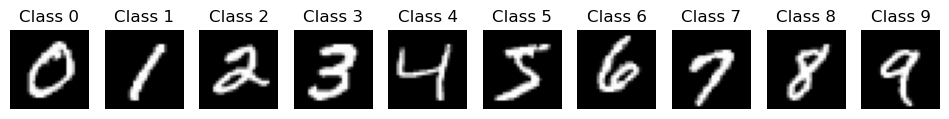

In [6]:
# Create a dictionary to store one sample for each class
samples = {}
for i in range(10):
    samples[i] = None
cpt=0
# Find the first occurrence of each class and store it in the dictionary
for data, target in train_dataset:
    if samples[target] is None:
        samples[target] = data
        cpt+=1
        if cpt==10:
            break

# Plot the samples
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(samples[i][0], cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.show()

In [7]:
# Create a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torch import optim
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [21]:
epochs = 100
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/100, loss = 0.031629
epoch : 2/100, loss = 0.018255
epoch : 3/100, loss = 0.016148
epoch : 4/100, loss = 0.015086
epoch : 5/100, loss = 0.014424
epoch : 6/100, loss = 0.013952
epoch : 7/100, loss = 0.013590
epoch : 8/100, loss = 0.013333
epoch : 9/100, loss = 0.013114
epoch : 10/100, loss = 0.012929
epoch : 11/100, loss = 0.012778
epoch : 12/100, loss = 0.012648
epoch : 13/100, loss = 0.012539
epoch : 14/100, loss = 0.012429
epoch : 15/100, loss = 0.012343
epoch : 16/100, loss = 0.012259
epoch : 17/100, loss = 0.012198
epoch : 18/100, loss = 0.012122
epoch : 19/100, loss = 0.012065
epoch : 20/100, loss = 0.012022
epoch : 21/100, loss = 0.011971
epoch : 22/100, loss = 0.011804
epoch : 23/100, loss = 0.011698
epoch : 24/100, loss = 0.011666
epoch : 25/100, loss = 0.011642
epoch : 26/100, loss = 0.011602
epoch : 27/100, loss = 0.011582
epoch : 28/100, loss = 0.011554
epoch : 29/100, loss = 0.011528
epoch : 30/100, loss = 0.011510
epoch : 31/100, loss = 0.011482
epoch : 32/100, l

KeyboardInterrupt: 

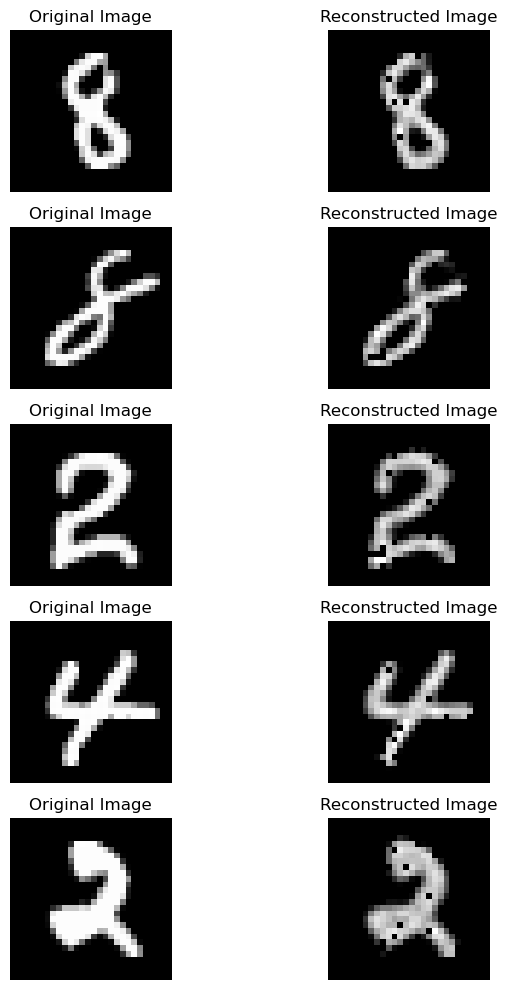

In [22]:
# Select random images from the test set and reconstruct them
num_images = 5
selected_indices = torch.randint(len(test_dataset), size=(num_images,))
reconstructed_images = []
original_images = []
for idx in selected_indices:
    image, _ = test_dataset[idx]
    original_images.append(image[0])
    with torch.no_grad():
        reconstructed_image = model(image.cuda().unsqueeze(0))
        reconstructed_images.append(reconstructed_image.squeeze().detach().cpu().numpy().reshape(28,28))

# Plot the original and reconstructed images
fig, axes = plt.subplots(num_images, 2, figsize=(8, 2*num_images))
for i in range(num_images):
    axes[i, 0].imshow(original_images[i], cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[i], cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Scatter plot of latent space with respective class colors
latent_points = []
labels = []
with torch.no_grad():
    for images, targets in test_loader:
        latent = model.encoder(images.cuda().view(images.size(0), -1))
        latent_points.extend(latent.detach().cpu().numpy())
        labels.extend(targets.numpy())

In [24]:
latent_points = np.array(latent_points)
labels = np.array(labels)


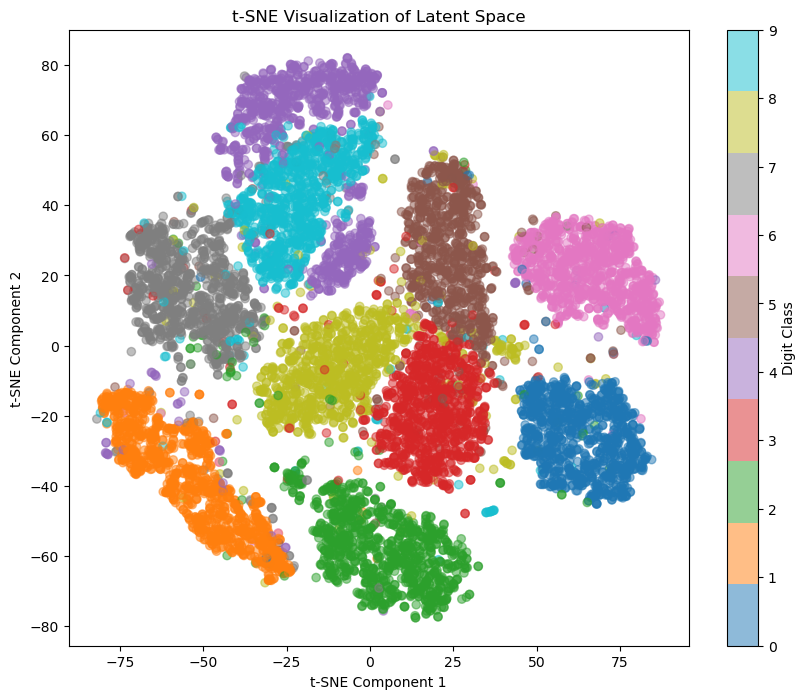

In [25]:
from sklearn.manifold import TSNE
# Apply t-SNE to reduce the dimensionality of the latent representations to 2D
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_points)

# Plot the 2D latent representations
plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_dataset.targets, cmap='tab10', alpha=0.5)
plt.colorbar(label='Digit Class')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space')
plt.show()

In [26]:
# Randomly select two latent points from the test set
selected_indices = np.random.choice(len(latent_points), 2, replace=False)
selected_latent = latent_points[selected_indices]
selected_latent_2d = latent_2d[selected_indices]
selected_labels = labels[selected_indices]

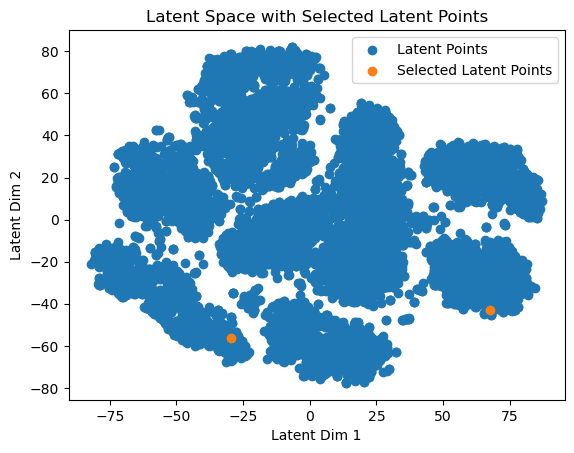

In [27]:
# Plot latent space with class colors
plt.scatter(latent_2d[:, 0], latent_2d[:, 1],label='Latent Points')
plt.scatter(selected_latent_2d[:, 0], selected_latent_2d[:, 1], label='Selected Latent Points')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space with Selected Latent Points')
plt.legend()
plt.show()


In [28]:
latent1, latent2 = torch.from_numpy(selected_latent)

# Interpolate between the two selected latent points
interpolation_points = torch.zeros((10, z_dim))
for i in range(10):
    interpolation_points[i] = latent1 + (latent2 - latent1) * i / 9

In [29]:
# Decode the interpolated latent points
with torch.no_grad():
    decoded_images = model.decoder(interpolation_points.cuda()).detach().cpu().numpy().reshape(-1,28,28)



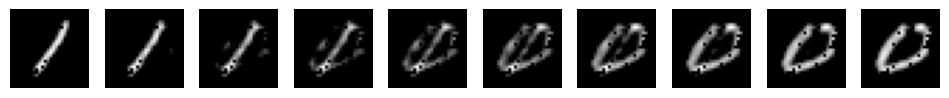

In [30]:
# Plot the decoded images
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(decoded_images[i], cmap='gray')
    axes[i].axis('off')
plt.show()